In [1]:
install.packages("GGally")
library(tidyverse)
library(tidymodels)
library(patchwork)
library(GGally)
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks strin

In [2]:
hungarian_data <- read_delim("processed.hungarian.data", delim = ",", col_names = FALSE)
colnames(hungarian_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

cleveland_data <- read_delim("processed.cleveland.data", delim = ",", col_names = FALSE)
colnames(cleveland_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

switzerland_data <- read_delim("processed.switzerland.data", delim = ",", col_names = FALSE)
colnames(switzerland_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

va_data <- read_delim("processed.va.data", delim = ",", col_names = FALSE)
colnames(va_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

stacked_data <- rbind(hungarian_data, va_data, switzerland_data, cleveland_data)
head(stacked_data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,slope_type,num_coloured_flourosopy,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


In [3]:
editedData <- stacked_data

idx <- editedData == "?"
# replace "?" values with NA
is.na(editedData) <- idx

navalues <- colSums(is.na(editedData))
navalues

#Removing columns with too many NA values and then removing observations with NA
editedData <- editedData |>
    select(-slope_type, -num_coloured_flourosopy, -thal) |>
    na.omit()
for(i in 1:nrow(editedData)) {       # for-loop over rows
    if(editedData$sex[i] == 1){
      editedData$sex[i] <- "Male"
    }else{
      editedData$sex[i]<- "Female"
      }
    
    if(editedData$chest_pain_type[i] == 1){
      editedData$chest_pain_type[i] <- "Typical Angina"
    }

    if(editedData$chest_pain_type[i] == 2){
      editedData$chest_pain_type[i] <- "Atypical Angina"
    }

    if(editedData$chest_pain_type[i] == 3){
      editedData$chest_pain_type[i] <- "Non-Anginal Pain"
    }

    if(editedData$chest_pain_type[i] == 4){
      editedData$chest_pain_type[i] <- "Asymptomatic"
    }

#    if(editedData$diagnosis[i] == 0){
#      editedData$diagnosis[i] <- "< 50% Diameter Narrowing"
#    }else{
#      editedData$diagnosis[i] <- "> 50% Diameter Narrowing"
#    }  

    if(!is.na(editedData$rest_ecg_results[i])){
       if(editedData$rest_ecg_results[i] == 0){
          editedData$rest_ecg_results[i] <- "Normal"
             }
    
        if(editedData$rest_ecg_results[i] == 1){
          editedData$rest_ecg_results[i] <- "ST-T Wave Abnormality"
             }
    
         if(editedData$rest_ecg_results[i] == 2){
          editedData$rest_ecg_results[i] <- "Probable or Definite Left Ventricular Hypertrophy"
             }
        
        }

 if(!is.na(editedData$fasting_bs[i])){

    if(editedData$fasting_bs[i] == 0){
          editedData$fasting_bs[i] <- "False"
             }
    
    if(editedData$fasting_bs[i] == 1){
          editedData$fasting_bs[i] <- "True"
             }
     }

    
     if(!is.na(editedData$exercise_angina[i])){
        if(editedData$exercise_angina[i] == 0){
              editedData$exercise_angina[i] <- "No"
                 }
        
        if(editedData$exercise_angina[i] == 1){
              editedData$exercise_angina[i] <- "Yes"
                 }
         }

}
#Removing incorrect 0 values
 editedData <- editedData |>
    filter(age != 0) |>
    filter(rest_bp != 0) |>
    filter(serum_cholesterol != 0) |>
    filter(max_heartrate != 0)
#Changing data types
editedData <- editedData |>
    mutate(sex = as.factor(sex)) |>
    mutate(chest_pain_type = as.factor(chest_pain_type)) |>
    mutate(rest_bp = as.numeric(rest_bp)) |>
    mutate(serum_cholesterol = as.numeric(serum_cholesterol)) |>
    mutate(fasting_bs = as.factor(fasting_bs)) |>
    mutate(rest_ecg_results = as.factor(rest_ecg_results)) |>
    mutate(max_heartrate = as.numeric(max_heartrate)) |>
    mutate(exercise_angina = as.factor(exercise_angina)) |>
    mutate(st_depression = as.numeric(st_depression)) |>
    mutate(diagnosis = as.factor(diagnosis))
head(editedData)

age                     sex         chest_pain_type 
                      0                       0                       0 
                rest_bp       serum_cholesterol              fasting_bs 
                     59                      30                      90 
       rest_ecg_results           max_heartrate         exercise_angina 
                      2                      55                      55 
          st_depression              slope_type num_coloured_flourosopy 
                     62                     309                     611 
                   thal               diagnosis 
                    486                       0

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>
28,Male,Atypical Angina,130,132,False,Probable or Definite Left Ventricular Hypertrophy,185,No,0,0
29,Male,Atypical Angina,120,243,False,Normal,160,No,0,0
30,Female,Typical Angina,170,237,False,ST-T Wave Abnormality,170,No,0,0
31,Female,Atypical Angina,100,219,False,ST-T Wave Abnormality,150,No,0,0
32,Female,Atypical Angina,105,198,False,Normal,165,No,0,0
32,Male,Atypical Angina,110,225,False,Normal,184,No,0,0


In [4]:
set.seed(100)

data_split <- initial_split(editedData, prop = 0.75, strata = chest_pain_type)
data_train <- training(data_split)
data_test <- testing(data_split) 

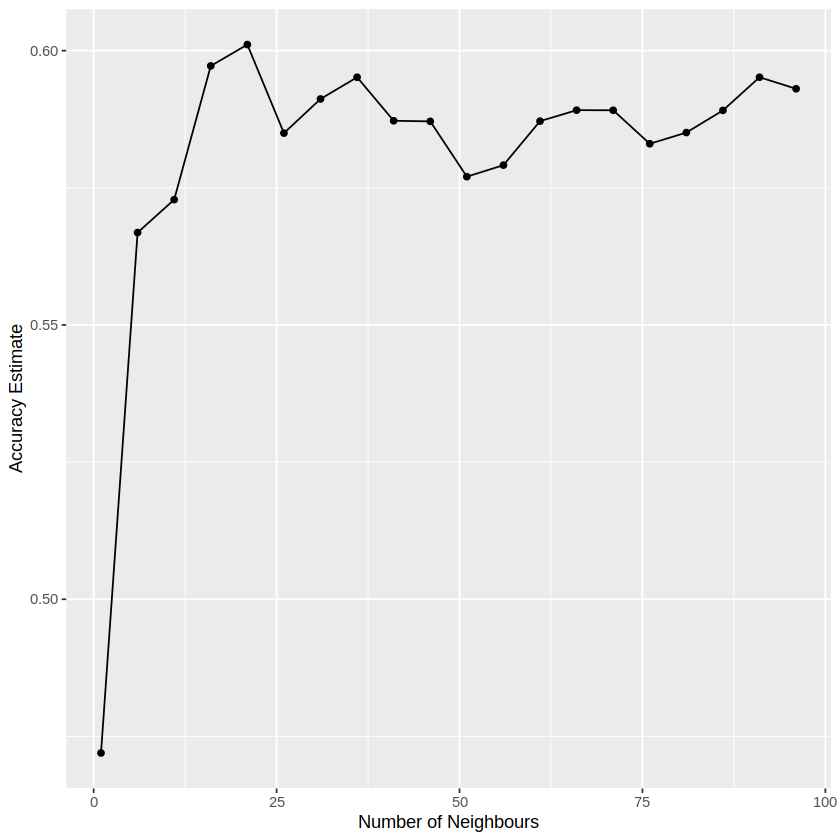

In [5]:
set.seed(100)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_recipe <- recipe(chest_pain_type ~ ., data = data_train) |>
    step_scale(age, serum_cholesterol, rest_bp, max_heartrate, st_depression) |>
    step_center(age, serum_cholesterol, rest_bp, max_heartrate, st_depression)

heart_refold <- vfold_cv(data_train, v = 5, strata = chest_pain_type)

k_vals_wide <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

resample_results_wide <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = heart_refold, grid = k_vals_wide) |>
    collect_metrics()

cross_val_plot_wide <- resample_results_wide |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbours", y = "Accuracy Estimate")
cross_val_plot_wide

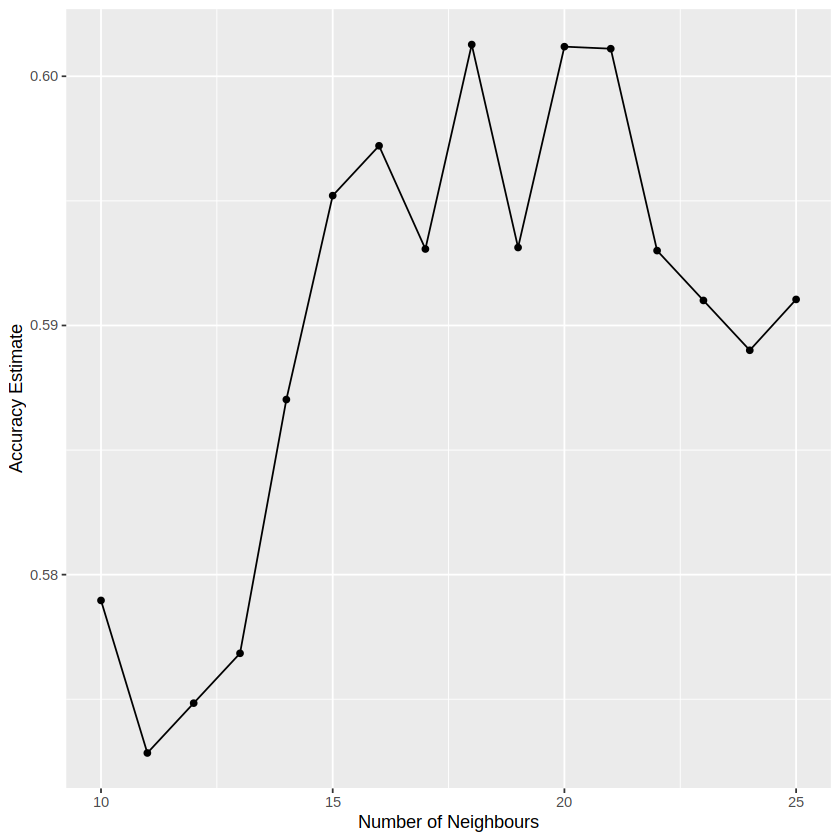

In [6]:
set.seed(100)

k_vals <- tibble(neighbors = seq(from = 10, to = 25, by = 1))

resample_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = heart_refold, grid = k_vals) |>
    collect_metrics()

optimal_neighbors <- resample_results |>
    filter(.metric == "accuracy") |>
    slice_max(mean) |>
    pull(neighbors)

cross_val_plot <- resample_results |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbours", y = "Accuracy Estimate")
cross_val_plot

## Title 

### Chest Pain Classification Using KNN

## Introduction 

### Background Information:
Heart disease refers to a range of conditions that affect the heart. Various factors, such as age, lifestyle, and genetics, can influence the chances of an individual getting heart disease. We want to understand what factors are related to certain chest pain types.

The KNN algorithim works as follows, based on the K (this can be any number eg: 1,2,3) nearest neighbors, we will take the classification of them and say this observation is of that classification. We use proximity to make classifications or predictions about the grouping of an individual data point.

Example: If a certain observation has an unknown classification and it's K nearest neighbors are all of type "Burger" then this observation will be of type burger!

### The Question:
Can we determine what type of chest pain a patient is likely experiencing based on only their age and cholesterol levels?

### Dataset:
The dataset that we will be using is titled “Heart Disease”.  It contains observations from various locations published as 4 experiment databases, each including the same subset of 14 attributes. For ease of reading, we chose to use the processed experiment files for our data.


## Methods & Results

### Pre Analysis:

To read the data, we first downloaded the data set. We then looked through the files and realized that only the processed data was likely to be readable with our current knowledge, and thus chose to use the 4 processed files.
<br>

After reading the files and looking through the heart-disease.names file for the descriptions of each attribute, we gave the table columns appropriate names to ensure the data would be understandable.
Below is the original data with added column names:

In [7]:
hungarian_data <- read_delim("processed.hungarian.data", delim = ",", col_names = FALSE)
colnames(hungarian_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

cleveland_data <- read_delim("processed.cleveland.data", delim = ",", col_names = FALSE)
colnames(cleveland_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

switzerland_data <- read_delim("processed.switzerland.data", delim = ",", col_names = FALSE)
colnames(switzerland_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

va_data <- read_delim("processed.va.data", delim = ",", col_names = FALSE)
colnames(va_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

stacked_data <- rbind(hungarian_data, va_data, switzerland_data, cleveland_data)
head(stacked_data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,slope_type,num_coloured_flourosopy,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


After giving the data the correct columns, we stacked the data together to make the analyzation process easier. The next step in tidying the data was to give values within each observation the appropriate category, and to remove all NA values.

In [8]:
editedData <- stacked_data

idx <- editedData == "?"
# replace "?" values with NA
is.na(editedData) <- idx

navalues <- colSums(is.na(editedData))
navalues

age                     sex         chest_pain_type 
                      0                       0                       0 
                rest_bp       serum_cholesterol              fasting_bs 
                     59                      30                      90 
       rest_ecg_results           max_heartrate         exercise_angina 
                      2                      55                      55 
          st_depression              slope_type num_coloured_flourosopy 
                     62                     309                     611 
                   thal               diagnosis 
                    486                       0

In [9]:
#Removing columns with too many NA values and then removing observations with NA
editedData <- editedData |>
    select(-slope_type, -num_coloured_flourosopy, -thal) |>
    na.omit()

In [10]:
for(i in 1:nrow(editedData)) {       # for-loop over rows
    if(editedData$sex[i] == 1){
      editedData$sex[i] <- "Male"
    }else{
      editedData$sex[i]<- "Female"
      }
    
    if(editedData$chest_pain_type[i] == 1){
      editedData$chest_pain_type[i] <- "Typical Angina"
    }

    if(editedData$chest_pain_type[i] == 2){
      editedData$chest_pain_type[i] <- "Atypical Angina"
    }

    if(editedData$chest_pain_type[i] == 3){
      editedData$chest_pain_type[i] <- "Non-Anginal Pain"
    }

    if(editedData$chest_pain_type[i] == 4){
      editedData$chest_pain_type[i] <- "Asymptomatic"
    }

    if(editedData$diagnosis[i] == 0){
      editedData$diagnosis[i] <- "< 50% Diameter Narrowing"
    }else{
      editedData$diagnosis[i] <- "> 50% Diameter Narrowing"
    }  

    if(!is.na(editedData$rest_ecg_results[i])){
       if(editedData$rest_ecg_results[i] == 0){
          editedData$rest_ecg_results[i] <- "Normal"
             }
    
        if(editedData$rest_ecg_results[i] == 1){
          editedData$rest_ecg_results[i] <- "ST-T Wave Abnormality"
             }
    
         if(editedData$rest_ecg_results[i] == 2){
          editedData$rest_ecg_results[i] <- "Probable or Definite Left Ventricular Hypertrophy"
             }
        
        }

 if(!is.na(editedData$fasting_bs[i])){

    if(editedData$fasting_bs[i] == 0){
          editedData$fasting_bs[i] <- "False"
             }
    
    if(editedData$fasting_bs[i] == 1){
          editedData$fasting_bs[i] <- "True"
             }
     }

    
     if(!is.na(editedData$exercise_angina[i])){
        if(editedData$exercise_angina[i] == 0){
              editedData$exercise_angina[i] <- "No"
                 }
        
        if(editedData$exercise_angina[i] == 1){
              editedData$exercise_angina[i] <- "Yes"
                 }
         }
}

In [11]:
#Removing incorrect 0 values
editedData <- editedData |>
    filter(age != 0) |>
    filter(rest_bp != 0) |>
    filter(serum_cholesterol != 0) |>
    filter(max_heartrate != 0)

In [12]:
#Changing data types
editedData <- editedData |>
    mutate(sex = as.factor(sex)) |>
    mutate(chest_pain_type = as.factor(chest_pain_type)) |>
    mutate(rest_bp = as.numeric(rest_bp)) |>
    mutate(fasting_bs = as.factor(fasting_bs)) |>
    mutate(rest_ecg_results = as.factor(rest_ecg_results)) |>
    mutate(max_heartrate = as.numeric(max_heartrate)) |>
    mutate(exercise_angina = as.factor(exercise_angina)) |>
    mutate(st_depression = as.numeric(st_depression)) |>
    mutate(diagnosis = as.factor(diagnosis))

After these methods, we are left with this data!

Here is a sample of our data below which also marks the end of our tidying.

In [13]:
head(editedData)

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<chr>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>
28,Male,Atypical Angina,130,132,False,Probable or Definite Left Ventricular Hypertrophy,185,No,0,< 50% Diameter Narrowing
29,Male,Atypical Angina,120,243,False,Normal,160,No,0,< 50% Diameter Narrowing
30,Female,Typical Angina,170,237,False,ST-T Wave Abnormality,170,No,0,< 50% Diameter Narrowing
31,Female,Atypical Angina,100,219,False,ST-T Wave Abnormality,150,No,0,< 50% Diameter Narrowing
32,Female,Atypical Angina,105,198,False,Normal,165,No,0,< 50% Diameter Narrowing
32,Male,Atypical Angina,110,225,False,Normal,184,No,0,< 50% Diameter Narrowing


### Analysis Methods:

In our analysis, we will use cholesterol, resting blood pressure, max heart rate, ST-depression, exercise angina, and diagnosis as our predictors. We chose many predictors as our preliminary visualizations did not indicate a particularly strong correlation between any of the individual predictors and chest pain type, and thus must use a large range of predictors which may allow the classifier to narrow down what category of chest pain to assign to a new observation. We eliminated sex, blood sugar, and ECG measurements as they seemed to distribute very similarly across all pain types. 
<br>

For our final visualization, we plan on creating a scatterplot matrix showing how each variable relates to another. The shape and colour of each point will correspond to its chest pain type, and we can visualize new observations across the multiple grids to see if our predictors do a good job of evaluating the likely class of the new observation. 

### Implementation Of Analysis Methods:

### Visualization Of Analysis:

## Discussion

### What We Found:

### Is This What We Expected:

### Impact Of Findings:

### Future Questions:

## References

1. [Heart Disease and Stroke](https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart,unhealthy%20diet%2C%20and%20physical%20inactivity.), Centers for Disease Control and Prevention, September, 2022 

2. [Risk Factors for Coronary Artery Disease: Historical Perspectives](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5686931/), Rachel Hajar, July, 2017 